In [1]:
import pandas as pd
import numpy as np
import joblib
import glob
from math import sqrt

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, shapiro

from statsmodels.graphics.gofplots import qqplot
from matplotlib import pyplot

# Single Variable Prediction

In [77]:
### Loading up Variables:
def get_data(pollutant, city):
    train_X = joblib.load("data/train/{}/X/{}.joblib".format(pollutant, city))
    train_y = joblib.load("data/train/{}/y/{}.joblib".format(pollutant, city))
    valid_X = joblib.load("data/valid/{}/X/{}.joblib".format(pollutant, city))
    valid_y = joblib.load("data/valid/{}/y/{}.joblib".format(pollutant, city))
    test_X = joblib.load("data/test/{}/X/{}.joblib".format(pollutant, city))
    test_y = joblib.load("data/test/{}/y/{}.joblib".format(pollutant, city))

    return (train_X, train_y, valid_X, valid_y, test_X, test_y)

def get_unsplit_data(city):
    return joblib.load("data/full_splits/{}.joblib".format(city))

def idx2CityName(idx):
    mapping = {0 : 'Aotizhongxin', 
     1 : 'Changping',
     2 : 'Dingling',
     3 : 'Dongsi',
     4 : 'Guanyuan',
     5 : 'Gucheng',
     6 : 'Huairou',
     7 : 'Nongzhanguan',
     8 : 'Shunyi',
     9 : 'Tiantan',
     10 : 'Wanliu',
     11 : 'Wanshouxigong'}
    
    return mapping[idx]

def cityName2Idx(cityName):
    mapping = {'Aotizhongxin' : 0, 
     'Changping' : 1,
     'Dingling' : 2,
     'Dongsi' : 3,
     'Guanyuan' : 4,
     'Gucheng' : 5,
     'Huairou' : 6,
     'Nongzhanguan' : 7,
     'Shunyi' : 8,
     'Tiantan' : 9,
     'Wanliu' : 10,
     'Wanshouxigong' : 11}
    
    return mapping[cityName]

def split(df, resp_col):
    cols = df.columns
    pred_cols = [pred_col for pred_col in cols if pred_col is not resp_col]
    X = df[pred_cols]
    y = df[resp_col]
    
    
    return X, y

def perform_grid_search_cross_validation(model, X_train, y_train, grid_param, scoring='accuracy', cv=5, n_jobs=1):
    gd_sr = GridSearchCV(estimator=model, param_grid=grid_param, scoring=scoring, cv=cv, n_jobs=n_jobs)
    gd_sr.fit(X_train, y_train)
    return gd_sr.best_params_
    

def validate_prediction(y, y_pred):
    mse = mean_squared_error(y, y_pred)
    mae = mean_absolute_error(y, y_pred)

    return "mse = {mse} & mae = {mae} & rmse = {rmse}".format(mse=mse, mae=mae, rmse=sqrt(mse))

### Pollutant: SO2

In [15]:
dfs = []
for idx in range(0,12):
    df = get_unsplit_data("SO2", idx2CityName(idx))
    dfs.append(df)
full_dataset = pd.concat(dfs)

#full_dataset = pd.get_dummies(full_dataset, columns=['station', 'wd'])
full_dataset.drop(['timestamp', 'station', 'wd'],inplace=True,axis=1)

In [21]:
X, y = split(full_dataset, "SO2")

[0.56505509 0.20918635 0.07549117 0.0474487  0.0355171 ]


Index(['PM2.5', 'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'WSPM'], dtype='object')

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

In [48]:
neigh = KNeighborsRegressor(n_neighbors=6, n_jobs=3)
neigh.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=3, n_neighbors=6, p=2,
                    weights='uniform')

In [49]:
y_pred = neigh.predict(X_val)

errors_on_train = validate_prediction(y_train, neigh.predict(X_train))
errors_on_val = validate_prediction(y_val, y_pred)
print("Train: {}".format(errors_on_train))
print("Validation: {}".format(errors_on_val))

Train: mse = 0.000105577988425563 & mae = 0.0069512517818035476 & rmse = 0.010275115007899571
Validation: mse = 0.00015140292917303636 & mae = 0.008400112651478624 & rmse = 0.012304589760452657


In [47]:
neigh = KNeighborsRegressor()
parameters = {'n_neighbors':list(range(5,12))}

perform_grid_search_cross_validation(neigh, X_train, y_train, parameters, scoring='r2', cv=5, n_jobs=5)

{'n_neighbors': 6}

In [50]:
X_train.head()

,PM2.5,SO2,NO2,CO,O3,TEMP,PRES,DEWP,WSPM
2337,0.159128,0.149190,0.472656,0.121212,0.003137,0.613126,0.371585,0.834633,0.066667
18994,0.220903,0.103065,0.306273,0.151515,0.150816,0.683938,0.320583,0.778471,0.085714
26674,0.233485,0.229358,0.294026,0.181818,0.077605,0.437931,0.493530,0.513644,0.090000
13230,0.008939,0.005032,0.201389,0.050505,0.004224,0.581152,0.361854,0.811912,0.098214
13267,0.038153,0.013913,0.148594,0.113402,0.432621,0.768293,0.228471,0.804075,0.113636


In [51]:
training_res = y_train - neigh.predict(X_train)
holdout_res = y_val - y_pred

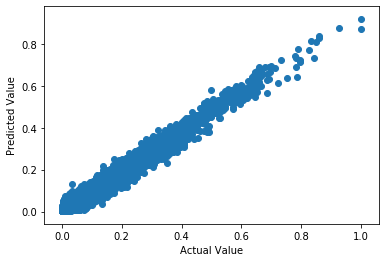

In [55]:
# Plotting Residuals 
plt.scatter(y_val, y_pred)
plt.xlabel('Actual Value')
plt.ylabel('Predicted Value')
plt.show()

In [58]:
## T-Test and F-Test 
print(ttest_ind(y_val,y_pred))

Ttest_indResult(statistic=4.57491981942156, pvalue=4.768264293942768e-06)

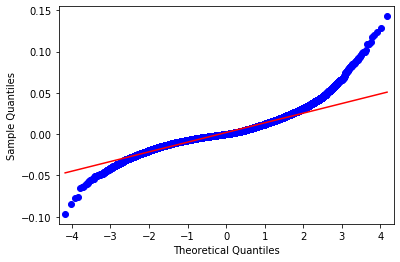

In [70]:
# q-q plot
qqplot(holdout_res, line='r')
pyplot.show()

### Pollutant: NO2

In [71]:
dfs = []
for idx in range(0,12):
    df = get_unsplit_data("NO2", idx2CityName(idx))
    dfs.append(df)
full_dataset = pd.concat(dfs)

#full_dataset = pd.get_dummies(full_dataset, columns=['station', 'wd'])
full_dataset.drop(['timestamp', 'station', 'wd'],inplace=True,axis=1)

In [72]:
X, y = split(full_dataset, "NO2")

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

In [74]:
neigh = KNeighborsRegressor(n_neighbors=6, n_jobs=3)
neigh.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=3, n_neighbors=6, p=2,
                    weights='uniform')

In [75]:
y_pred = neigh.predict(X_val)

errors_on_train = validate_prediction(y_train, neigh.predict(X_train))
errors_on_val = validate_prediction(y_val, y_pred)
print("Train: {}".format(errors_on_train))
print("Validation: {}".format(errors_on_val))

neigh = KNeighborsRegressor()
parameters = {'n_neighbors':list(range(5,12))}

res = perform_grid_search_cross_validation(neigh, X_train, y_train, parameters, scoring='r2', cv=5, n_jobs=5)
print(res)

Train: mse = 0.00012673917106321127 & mae = 0.00831020689763928 & rmse = 0.011257849308958229
Validation: mse = 0.00018032407247466452 & mae = 0.009849363209637297 & rmse = 0.013428479901860245
{'n_neighbors': 9}


In [76]:
training_res = y_train - neigh.predict(X_train)
holdout_res = y_val - y_pred

NotFittedError: This KNeighborsRegressor instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.

In [ ]:
# Plotting Residuals 
plt.scatter(y_val, y_pred)
plt.xlabel('Actual Value')
plt.ylabel('Predicted Value')
plt.show()

### Pollutant: O3

### Pollutant: CO

### Pollutant: PM2.5